# Titanic: Machine Learning from Disaster
Predict survival on the Titanic and get familiar with ML basics
<a href="https://www.kaggle.com/c/titanic/">Kaggle prediction Competition</a>

In [78]:
#import the necessary libraries for dataset preparation, feature engineering, model training
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd, string, xgboost
from scipy import stats
from scipy.stats import randint
#import required packages
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, ShuffleSplit
from math import sqrt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

In [3]:
#Import Training and Testing Data
train = pd.read_csv('train.csv')
print("Training Set:"% train.columns, train.shape)
test = pd.read_csv('test.csv')
print("Test Set:"% test.columns, test.shape)

Training Set: (891, 12)
Test Set: (418, 11)


In [4]:
#Percentage of Survived/Did not Survive shows that the training Data is not balanced.
print("Survived: ", train.Survived.value_counts()[1]/len(train)*100,"%")
print("Did not Survive: ", train.Survived.value_counts()[0]/len(train)*100,"%")

Survived:  38.38383838383838 %
Did not Survive:  61.61616161616161 %


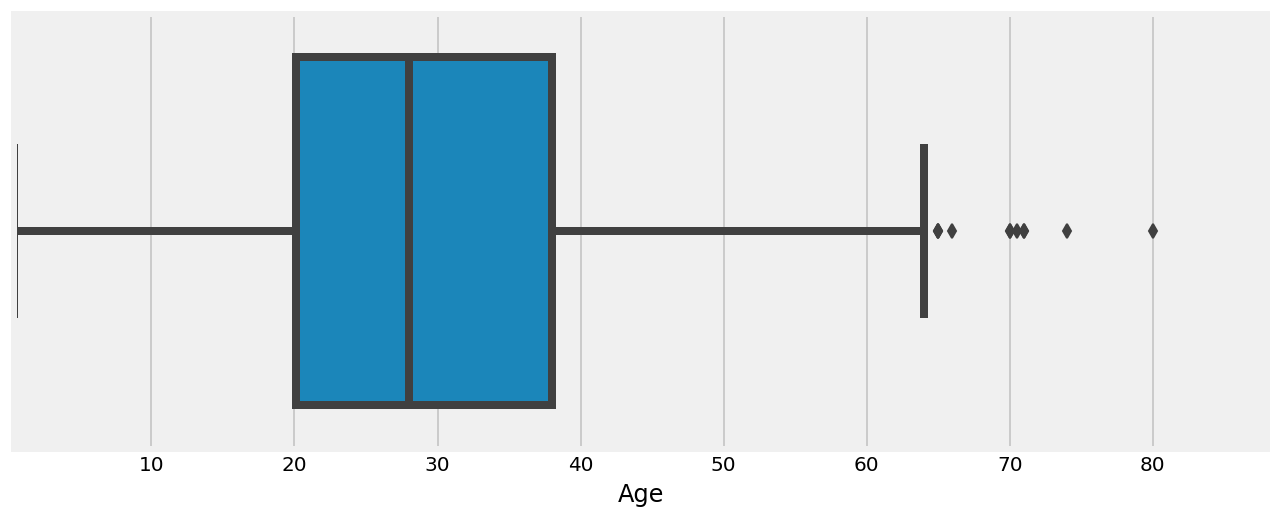

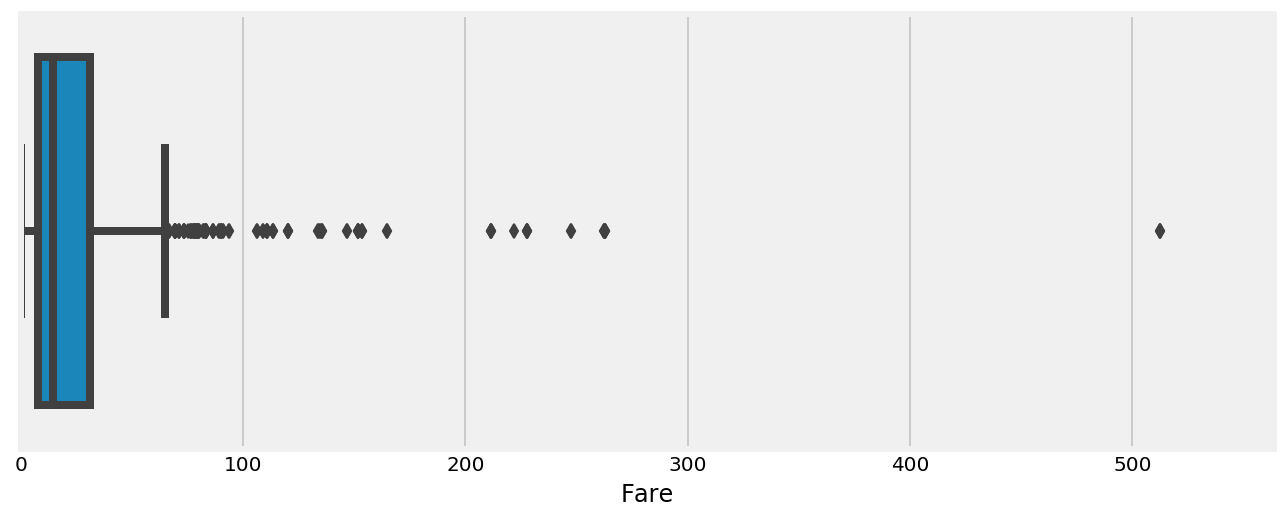

In [5]:
#Let us have a look at the Anomalies in the Dataset
plt.figure(figsize=(10,4))
plt.xlim(train.Age.min(), train.Age.max()*1.1)
sns.boxplot(x=train.Age)

plt.figure(figsize=(10,4))
plt.xlim(train.Fare.min(), train.Fare.max()*1.1)
sns.boxplot(x=train.Fare)

In [6]:
#We noticed that most of the passengers age is between 20 and 40, Let us see how many passengers are over 65. 
#Also the fare shows that most of people paid less than 100 Pounds per ticket.
train[train['Age']>=65]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


In [7]:
test[test['Age']>=65]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
81,973,1,"Straus, Mr. Isidor",male,67.0,1,0,PC 17483,221.7792,C55 C57,S
96,988,1,"Cavendish, Mrs. Tyrell William (Julia Florence Siegel)",female,76.0,1,0,19877,78.8500,C46,S


In [8]:
train[train['Fare']>=300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [9]:
test[test['Fare']>=300]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlotte Wardle Drake)",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [89]:
train=train[train['Age']<65]
train=train[train['Fare']<300]

In [12]:
# Obtain target and predictors
y = train.Survived.copy()
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[features].copy()
X_test = test[features].copy()

In [13]:
# Get list of categorical variables
Obj_Type = (X.dtypes == 'object')
object_cols = list(Obj_Type[Obj_Type].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Sex', 'Embarked']


In [14]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()

for col in object_cols:
    #make NAN as 0 Catgory Variable
    X_test[col] = label_encoder.fit_transform(X_test[col].fillna('0'))
    X[col] = label_encoder.fit_transform(X[col].fillna('0'))

In [15]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_test = pd.DataFrame(my_imputer.fit_transform(X_test))
imputed_X = pd.DataFrame(my_imputer.fit_transform(X))
# Imputation removed column names; put them back
imputed_X_test.columns = X_test.columns
imputed_X.columns = X.columns

In [16]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(imputed_X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [17]:
#Return the f1 Score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)    

    return metrics.f1_score(y_valid,predictions)

In [88]:
from sklearn.model_selection import KFold
clf_xgb = xgboost.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(140, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 12],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4, 6, 8]
             }

numFolds = 5
kfold_5 = KFold(n_splits = numFolds, shuffle = True)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.7s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
          error_score=0,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A7372AF60>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A73B04F60>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A73B04EF0>, 'max_depth': [3, 4, 5, 6, 7, 8, 9, 12], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A73

In [89]:
clf.best_params_

{'colsample_bytree': 0.6695364326839833,
 'learning_rate': 0.31119933475765166,
 'max_depth': 7,
 'min_child_weight': 6,
 'n_estimators': 624,
 'subsample': 0.7647275583620355}

In [90]:
clf.best_score_

0.8677329948787688

In [93]:
XGB = train_model(xgboost.XGBClassifier(learning_rate=0.1, n_estimators=169, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.9, colsample_bytree=0.8),X_train, y_train, X_valid)
print ("Result of XGB: ", XGB)

Result of XGB:  0.8159999999999998


In [81]:
#Now working with Real challenge Data
pr=xgboost.XGBClassifier(learning_rate=0.1, n_estimators=169, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
pr.fit(imputed_X, y)
predictions = pr.predict(imputed_X_test)
d={'PassengerId':test['PassengerId'],'Survived':predictions}
df=pd.DataFrame(data=d)
df.to_csv("test_predictions.csv", index=False)